In [1]:
import os
jdbcPathUbuntu = '/usr/share/java/postgresql-42.2.23.jar'
jdbcPathMacOS = '/Users/cristianomartinsm/postgresql-42.2.23.jar'
jdbcPath = jdbcPathUbuntu
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-class-path ' + jdbcPath + ' --jars ' + jdbcPath + ' pyspark-shell'
import psycopg2 as pg
import pandas as pd
import databricks.koalas as ks
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
from datetime import timedelta

In [2]:
kmLimit = 4000
folderData = 'Optimal Solutions/' + str(kmLimit) + '/'

dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        multiplierRounded = round(pricesMultiplier, 1)
        percentagePrice = int(multiplierRounded*100)
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                dataList.append((multiplierRounded, distanceCutOff, 4*float(optimalSolution["SolutionInfo"]["ObjVal"])))
        except FileNotFoundError:
            break

#dataFramePD = dataFrame.to_pandas()
dataFramePD = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'profit'])
dataFramePD = dataFramePD.pivot(index='multiplier', columns='distance', values='profit')
#dataFrame['multiplier'] = dataFrame.index
dataFramePD.sort_index(inplace=True)
#print(dataFramePD)
dataList = None

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


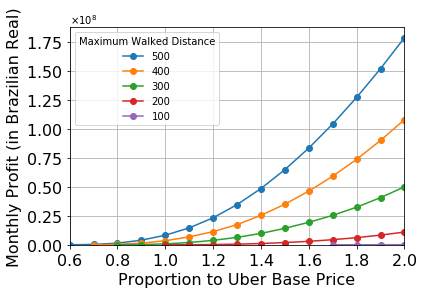

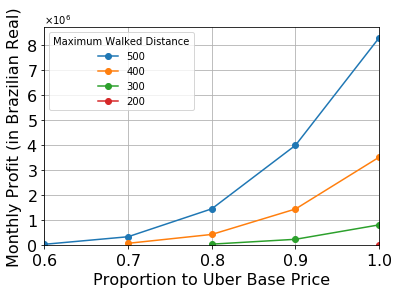

In [3]:
def formatFloat(value):
    numDecimaPlaces = 4
    return " & " + "{:.{nDigits}f}".format(value, nDigits=numDecimaPlaces)

def prepareGraph(dataFrame, xLabel, yLabel, legendTitle, fileName, xTicks=None, yTicks=None, tickFormat=None):
    #Showing legend items backwards. Reindexing is better than sorting the legend_handles because it maintains the color order.
    dataFrame = dataFrame.reindex(columns=sorted(dataFrame.columns, reverse=True))

    ax = dataFrame.plot.line(fontsize=16, grid=True, marker='o')
    ax.legend(title=legendTitle)
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(reversed(handles), reversed(labels)).set_title(legendTitle)

    ax.set_xlabel(xLabel, fontsize=16)
    ax.set_ylabel(yLabel, fontsize=16)

    ax.set_ylim([0, None])

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)

    if tickFormat == 'plain':
        ax.ticklabel_format(useOffset=False, style='plain')
    else:
        ax.ticklabel_format(scilimits=(-5, 3), useMathText=True)
    
    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

folderSave = Path('./IEEE T-ITS/' + str(kmLimit))
folderSave.mkdir(parents=True, exist_ok=True)

#PROFIT GRAPHS
fileName = folderSave / 'Profits.eps'
ax = prepareGraph(  dataFrame=dataFramePD,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Monthly Profit (in Brazilian Real)",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve())

lastXTick = 1
smallerDataFrame = dataFramePD[dataFramePD.index <= lastXTick].dropna(axis=1, how='all')
fileName = folderSave / 'Profits_until_1.eps'
minPercentage = min(smallerDataFrame.index)
maxValueAmongAllColumns = max(smallerDataFrame.max())
ax = prepareGraph(  dataFrame=smallerDataFrame,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Monthly Profit (in Brazilian Real)",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve(),
                    xTicks=np.linspace(minPercentage, lastXTick, num=5),
                    yTicks=np.arange(0, maxValueAmongAllColumns, pow(10, 6)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


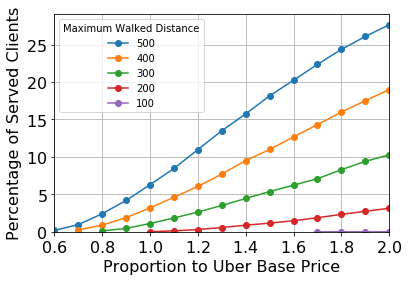

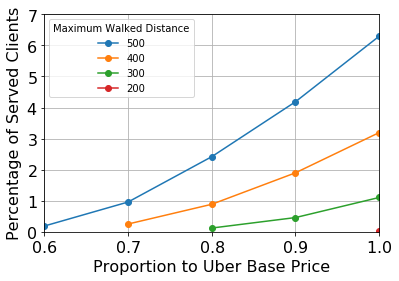

In [4]:
#SERVED CLIENTS GRAPH
def loadMaxAmountTrips():
    params = {'host':'localhost', 'port':'5432', 'database':'afterqualifying', 'user':'cristiano', 'password':'cristiano'}
    conn = pg.connect(**params)
    cur = conn.cursor()

    sqlQuery = '''	select	sum(floor(TRIP.TRIPEXPANSIONFACTOR))
                    from	TRIP;
                    '''
    cur.execute(sqlQuery)
    maxAmountTrips = cur.fetchone()[0]
    cur.close()
    conn.close()

    return maxAmountTrips

def loadTrips():
    params = {'host':'localhost', 'port':'5432', 'database':'afterqualifying', 'user':'cristiano', 'password':'cristiano'}
    conn = pg.connect(**params)

    sqlQuery = '''	select	TRIP.IDTRIP,
                            TRIP.TRIPEXPANSIONFACTOR,
                            TRIP.DRIVINGDISTANCE,
                            TRIP.DRIVINGDURATION,
                            TRIP.TIMESTAMPDEPARTURE,
                            TRIP.TIMESTAMPARRIVAL
                    from	TRIP
                    '''
    dataFrameEdges = pd.read_sql_query(sqlQuery, conn)
    conn.close()

    trips = dict()
    for row in dataFrameEdges.itertuples():
        dictRow = row._asdict()
        trip = Trip(idTrip=dictRow['idtrip'],
                    expansionFactor=dictRow['tripexpansionfactor'],
                    drivenDistance=dictRow['drivingdistance'],
                    drivenDuration=dictRow['drivingduration'],
                    timestampDeparture=dictRow['timestampdeparture'],
                    timestampArrival=dictRow['timestamparrival'])
        trips[trip.idTrip] = trip

    return trips

class Trip:
    #Values for defining the new timestamps
    ADJUSTED_MONTH = 1
    ADJUSTED_YEAR = 2017

    def adjustDay(timeDepartureOld, drivingDuration):
        #The weekday() starts from 0 but it does not exist a day 0 in the calendar. Then, a +1 solves this issue
        adjustedDayDeparture = timeDepartureOld.weekday() + 1

        timeDepartureNew = timeDepartureOld.replace(day=adjustedDayDeparture, month=Trip.ADJUSTED_MONTH, year=Trip.ADJUSTED_YEAR)
        timeArrivalNew = timeDepartureNew + timedelta(minutes=drivingDuration)
        
        return timeDepartureNew, timeArrivalNew

    def __init__(self, idTrip, expansionFactor, drivenDistance, drivenDuration, timestampDeparture, timestampArrival):
        self.idTrip = idTrip
        self.expansionFactor = expansionFactor
        self.drivenDistance = drivenDistance
        self.drivenDuration = drivenDuration
        self.timestampDepartureOld = timestampDeparture
        self.timestampArrivalOld = timestampArrival

        self.timestampDeparture, self.timestampArrival = Trip.adjustDay(timestampDeparture, self.drivenDuration)

maxAmountTrips = loadMaxAmountTrips()
allocatedStations = {}
amountServedTrips = {}
totalDrivenDistance = {}
trips = loadTrips()
dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        percentagePrice = int(round(pricesMultiplier*100, 0))
        keyTotalTrips = str(distanceCutOff) + '_' + str(percentagePrice)
        allocatedStations[keyTotalTrips] = 0
        amountServedTrips[keyTotalTrips] = 0
        totalDrivenDistance[keyTotalTrips] = 0
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                for var in optimalSolution["Vars"]:
                    varVTag = var["VTag"][0]
                    if varVTag.startswith('station') and varVTag.endswith('start'):
                        amountVehicles = int(var["X"])
                        if amountVehicles > 0:
                            allocatedStations[keyTotalTrips] += amountVehicles

                    elif varVTag.startswith('trip') and varVTag.endswith('filter'):
                        idTrip = int(varVTag.split('_')[1])
                        amountServed = int(var["X"])
                        if amountServed > 0:
                            amountServedTrips[keyTotalTrips] += amountServed
                            totalDrivenDistance[keyTotalTrips] += amountServed * trips[idTrip].drivenDistance/1000

                dataList.append((   pricesMultiplier,
                                    distanceCutOff,
                                    100*amountServedTrips[keyTotalTrips]/maxAmountTrips,
                                    allocatedStations[keyTotalTrips],
                                    4*totalDrivenDistance[keyTotalTrips]/allocatedStations[keyTotalTrips]))
        except FileNotFoundError:
            break

dataFrame = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'served', 'vehicles', 'drivendistance'])
dataFramePD = dataFrame.pivot(index='multiplier', columns='distance', values='served')
#dataFramePD['multiplier'] = dataFrame.index
dataFramePD.sort_index(inplace=True)
#print(dataFramePD)
dataList = None

fileName = folderSave / 'Served.eps'
ax = prepareGraph(  dataFrame=dataFramePD,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Percentage of Served Clients",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve())

dataFramePD = dataFrame.pivot(index='multiplier', columns='distance', values='served')
lastXTick = 1
smallerDataFrame = dataFramePD[dataFramePD.index <= lastXTick].dropna(axis=1, how='all')
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / 'Served_until_1.eps'
ax = prepareGraph(  dataFrame=smallerDataFrame,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Percentage of Served Clients",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve(),
                    xTicks=np.linspace(minPercentage, lastXTick, num=5),
                    yTicks=range(0, 8))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


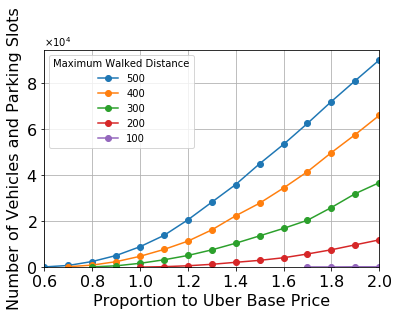

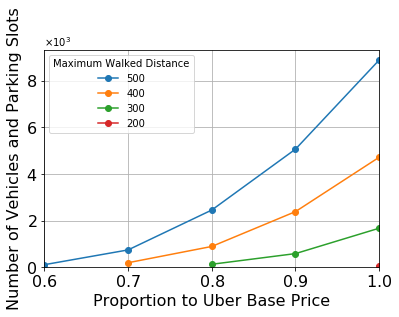

In [5]:
#NUMBER OF VEHICLES
dataFramePD = dataFrame.pivot(index='multiplier', columns='distance', values='vehicles')
#dataFramePD['multiplier'] = dataFrame.index
dataFramePD.sort_index(inplace=True)
#print(dataFramePD)
dataList = None

fileName = folderSave / 'Vehicles.eps'
ax = prepareGraph(  dataFrame=dataFramePD,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Number of Vehicles and Parking Slots",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve())

lastXTick = 1
smallerDataFrame = dataFramePD[dataFramePD.index <= lastXTick].dropna(axis=1, how='all')
maxValueAmongAllColumns = max(smallerDataFrame.max())
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / 'Vehicles_until_1.eps'
ax = prepareGraph(  dataFrame=smallerDataFrame,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Number of Vehicles and Parking Slots",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve(),
                    xTicks=np.linspace(minPercentage, lastXTick, num=5))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


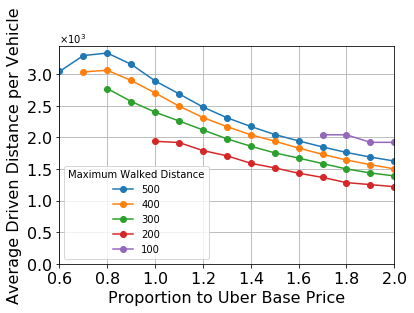

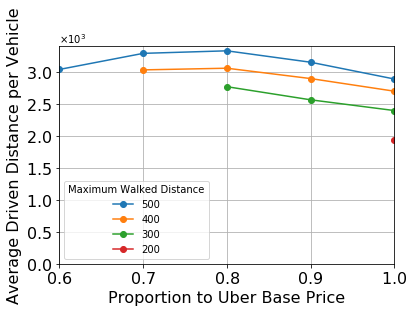

In [6]:
#AVERAGE DRIVEN DISTANCE PER VEHICLE
dataFramePD = dataFrame.pivot(index='multiplier', columns='distance', values='drivendistance')
#dataFramePD['multiplier'] = dataFrame.index
dataFramePD.sort_index(inplace=True)
#print(dataFramePD)

maxValueAmongAllColumns = max(dataFramePD.max())
fileName = folderSave / 'DrivenDistance.eps'
ax = prepareGraph(  dataFrame=dataFramePD,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Average Driven Distance per Vehicle",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve(),
                    yTicks=np.arange(0, maxValueAmongAllColumns, 500))

lastXTick = 1
smallerDataFrame = dataFramePD[dataFramePD.index <= lastXTick].dropna(axis=1, how='all')
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / 'DrivenDistance_until_1.eps'
ax = prepareGraph(  dataFrame=smallerDataFrame,
                    xLabel="Proportion to Uber Base Price",
                    yLabel="Average Driven Distance per Vehicle",
                    legendTitle='Maximum Walked Distance',
                    fileName=fileName.resolve(),
                    xTicks=np.linspace(minPercentage, lastXTick, num=5),
                    yTicks=np.arange(0, maxValueAmongAllColumns, 500))

In [7]:
allocatedStations = {}
dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        multiplierRounded = round(pricesMultiplier, 1)
        percentagePrice = int(multiplierRounded*100)
        keyTotalTrips = str(distanceCutOff) + '_' + str(percentagePrice)
        allocatedStations[keyTotalTrips] = list()
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                for var in optimalSolution["Vars"]:
                    varVTag = var["VTag"][0]
                    if varVTag.startswith('station') and varVTag.endswith('start'):
                        amountVehicles = int(var["X"])
                        if amountVehicles > 0:
                            allocatedStations[keyTotalTrips].append(amountVehicles)

                dataList.append((multiplierRounded, distanceCutOff, allocatedStations[keyTotalTrips]))
        except FileNotFoundError:
            break

AttributeError: 'AxesSubplot' object has no attribute 'xticks'

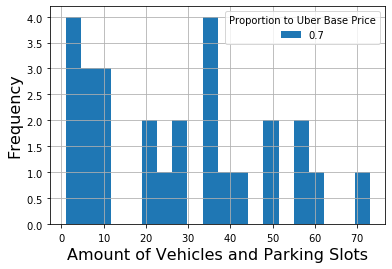

In [8]:
def prepareHistogram(dataFrame, xLabel, yLabel, legendTitle, fileName, amountBins=None, tickFormat=None, alpha=None):
    if amountBins is None:
        amountBins = 20
    if alpha is None:
        alpha = 1

    ax = dataFrame.plot.hist(bins=amountBins, alpha=alpha, grid=True)

    ax.legend(title=legendTitle)
    ax.set_xlabel(xLabel, fontsize=16)
    ax.set_ylabel(yLabel, fontsize=16)

    if tickFormat == 'plain':
        ax.ticklabel_format(useOffset=False, style='plain')
    else:
        ax.ticklabel_format(scilimits=(-5, 3), useMathText=True)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

dataFrame = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'vehicles'])
dataFramePD = dataFrame.pivot(index='multiplier', columns='distance', values='vehicles')
#dataFramePD['multiplier'] = dataFrame.index
dataFramePD.sort_index(inplace=True)
#print(dataFramePD)
dataList = None

dfHistogram1 = pd.DataFrame(dataFramePD[500][0.7],
                            columns = [0.7])
fileName = folderSave / 'Histogram_500_07.eps'
ax = prepareHistogram(  dataFrame=dfHistogram1,
                        xLabel='Amount of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20)

dfHistogram2 = pd.DataFrame(dataFramePD[500][2],
                            columns = [2])
fileName = folderSave / 'Histogram_500_2.eps'
ax = prepareHistogram(  dataFrame=dfHistogram2,
                        xLabel='Amount of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20)

dfHistogram = pd.concat([dfHistogram1, dfHistogram2], axis=1, ignore_index=True)
dfHistogram.rename(columns={0: '0.7', 1: '2'}, inplace=True)
fileName = folderSave / 'Histogram_500_07_2.eps'
ax = prepareHistogram(  dataFrame=dfHistogram,
                        xLabel='Amount of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20,
                        alpha=0.5)